In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
np.set_printoptions(suppress=True)

In [2]:
# Helper function for visualization
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [112]:
# Load the data and process it.

df = pd.read_csv("mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')

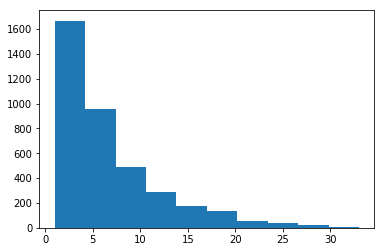

In [104]:
plt.hist(data['count'].values);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 3000/3000 [00:09<00:00, 309.74it/s]
The number of effective samples is smaller than 25% for some parameters.


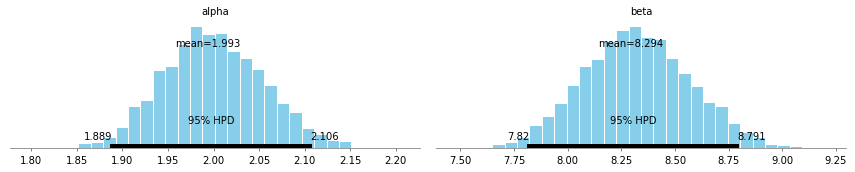

In [107]:
## For curiosity, lets try to recover the alpha/beta parameter by fitting observation frequency data
with pm.Model() as model0:
    alpha0 = pm.Uniform('alpha', 0, 100)
    beta0 = pm.Uniform('beta', 0, 100)
    X0 = pm.BetaBinomial('X', alpha=alpha0, beta=beta0, n=S, observed=data['count'].values)
    trace0 = pm.sample(2000, tune=1000, cores = 1)
    pm.plot_posterior(trace0, varnames = ['alpha', 'beta']);

In [43]:
# Summary of input

S = df['period'].max() + 1
V = len(workers)
freqs = data['count_history'].values
H = len(freqs)

print('Sampling periods:', S)
print('Unique patterns:', H)
print('Unique workers:', V)

Sampling periods: 36
Unique patterns: 3837
Unique workers: 46145


In [45]:
# We want to see the survival marks to compute the total survival
# e.g, Arrive: 1, Depart: 2 => 011
# Dims: SxSxS
def make_survival(S):
    mask = np.zeros([S,S,S])  # arrival, departure, presence_sequence
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            mask[s,q]= np.concatenate((c1, c2, c3))
    return mask
survival = tt.constant(make_survival(S))

In [46]:
# A more compact way to represent all Arrival and departures from the data
# This is part of the input data, so we preprocess it!
def get_hmask(S, H, data):
    h_mask = np.zeros((H,S,S))
    for wh in np.arange(H):
        f, l = data['min'].values[wh] , data['max'].values[wh]
        h_mask[wh, :f+1, l:] = 1
    return h_mask
hmask = tt.constant(get_hmask(S, H, data))
hmask.shape

Shape.0

In [47]:
# For a given outcome in {1,S} (Frequency of capture that's not 0) 
# Generate the Binomial parameters n and i   choose(n, i)
# Nn is the duration from arrival to departure
# Ni is the Frequency we are intersted in
# Dim: SxSxS
def make_binmask(S, data):
    i = data['count'].values
    i = i[:, np.newaxis, np.newaxis] *  np.ones((H, S, S))
    n = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (H, S, S))
    return tt.constant(i), tt.constant(n)
Ni, Nn = make_binmask(S, data)
print('Tensor with number of captures', Ni.shape)
print('Tensor with durations from first to last seen', Nn.shape)

Tensor with number of captures Shape.0
Tensor with durations from first to last seen Shape.0


In [48]:
# Helper functions for the Beta Bernoulli Process
# TODO: switch to a single function even for the special case of 0 captures.

def get_BetaBi(a,b, S, Ni, Nn):
    # The beta binomial
    BBi  =  bound(betaln(Ni + a, Nn - Ni + b) - betaln(a, b),
                     Ni >= 0, Ni <= Nn,
                     a > 0, b > 0)
    # The above is the computation of the log, so we take the exponent
    return tt.exp(BBi)

def get_BetaB0(a, b, S):
    # The beta binomial for 0 captures
    Nn = tt.triu(tt.ones([S,S]), 0).cumsum(axis =1).eval()
    #B0 = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    B0 = bound(betaln(a, Nn + b) - betaln(a, b), 
               a > 0, b > 0)
    return tt.exp(B0)

In [49]:
def logp_capture(arrival_probs, departure_probs, a, b, U, survival_mask, Ni, Nn, S, V):
    def ll_capture_f(Nh, data_first_last_mask):
          
        # Likelihood of observing Li captures
        
        # compute the survival
        survival_prob = tt.pow(1 - departure_probs, survival_mask)
        survival_prob = tt.prod(survival_prob, axis=2)
        # compute the arrival and departure
        LAD      = arrival_probs[:, np.newaxis] * survival_prob * departure_probs    # SxS
        # keep only true possibilites
        True_LAD = LAD * data_first_last_mask # SxSxS
        
        # sum along the freqencies of catpures
        BetaBi  = get_BetaBi(a, b, S, Ni, Nn)
        Li      = tt.batched_tensordot(True_LAD, BetaBi, axes = 2) # S
        
        # Likelihood of No-Capture L0
        
        True_LAD0    = LAD * tt.triu(tt.ones((S,S)), 0)
        BetaB0   = get_BetaB0(a, b, S)
        L0       = tt.sum(True_LAD0 * BetaB0)
        
        # Multinomial
        obj1 = tt.gammaln(V + U + 1) - tt.gammaln(U + 1) - tt.sum(tt.gammaln(Nh+1))
        obj2 = tt.sum(Nh * tt.log(Li))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [70]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=50000, upper=5000000)
    a = pm.Uniform('alpha', .0, .3)
    b = pm.Uniform('beta', 1., 10.)
    
    phi = tt.zeros(S)
    phi_v    = pm.Uniform('departure', 0.01, .1, shape=S-1)
    phi = tt.set_subtensor(phi[S-1], 1.)
    phi = tt.set_subtensor(phi[:S-1],phi_v)
    
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    #U_print = tt.printing.Print('Unseen')(U)
    #a_print = tt.printing.Print('alpha')(a)
    #b_print = tt.printing.Print('beta')(b)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, survival, Ni, Nn, S, V), 
                        observed={'Nh': freqs ,
                                  'data_first_last_mask': hmask })

# ADVI Sampling

In [75]:
# "Super fast Sampling" using ADVI
with model:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_vi = approx.sample(50000) 
    
    elbos1 = -inference.hist

Average Loss = 68,685: 100%|██████████| 20000/20000 [53:51<00:00,  6.19it/s]   
Finished [100%]: Average Loss = 68,684
Average Loss = 68,403: 100%|██████████| 10000/10000 [27:05<00:00,  6.15it/s]
Finished [100%]: Average Loss = 68,403


/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


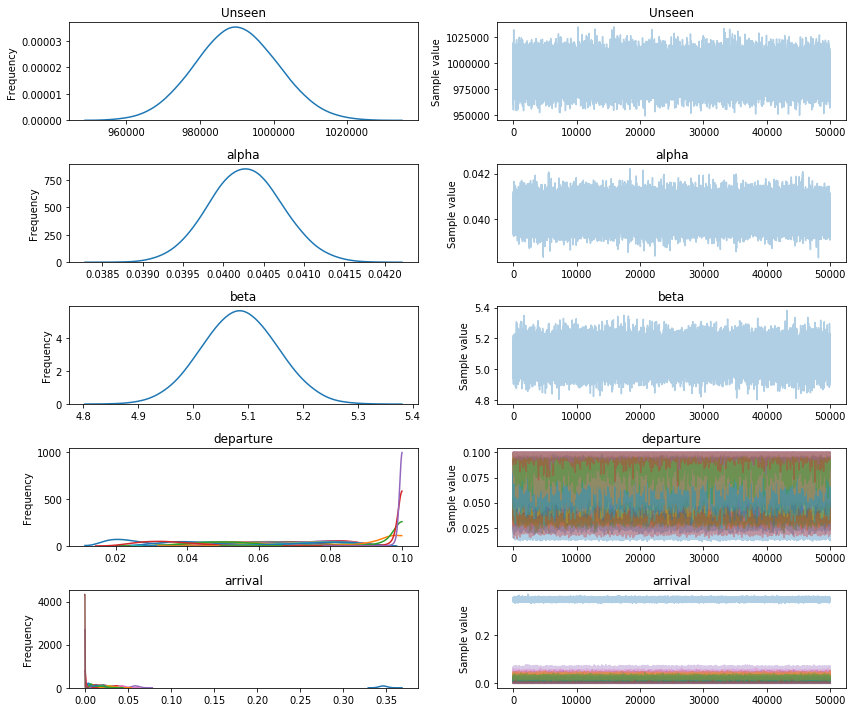

In [76]:
pm.traceplot(trace_vi);

<BarContainer object of 36 artists>

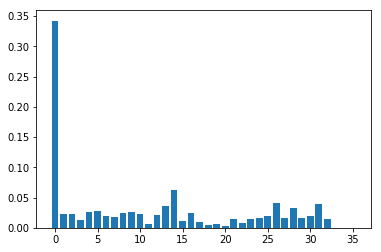

In [113]:
# Percentage of Super-population Arrivals
plt.bar(np.arange(S), trace_vi['arrival'][-1])

<BarContainer object of 35 artists>

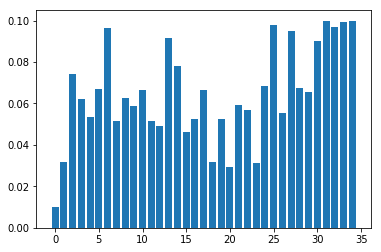

In [114]:
# Percentage of Departures
plt.bar(np.arange(S-1), posterior['departure'][-1])

# MCMC based Sampling

In [71]:
# Now we use precise sampling methods .. that take ages
with model:
  posterior = pm.sample(1000, tune = 1000,  chains = 1, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [arrival, departure, beta, alpha, Unseen]
100%|██████████| 2000/2000 [12:02:52<00:00, 21.69s/it]  
There were 713 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6888314781980803, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


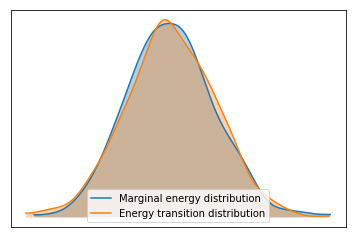

In [73]:
pm.energyplot(posterior);

/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


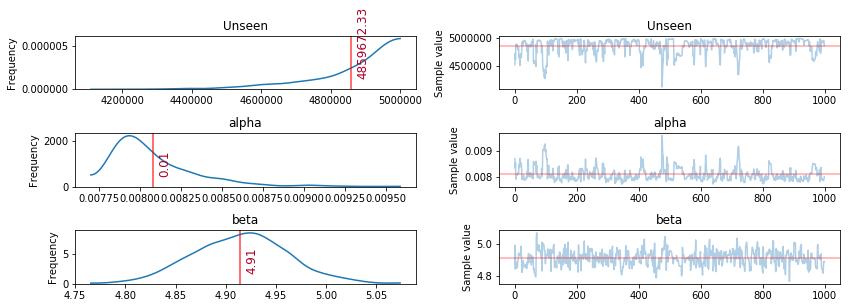

In [74]:
plot_traces(posterior, varnames = ['Unseen', 'alpha', 'beta']);

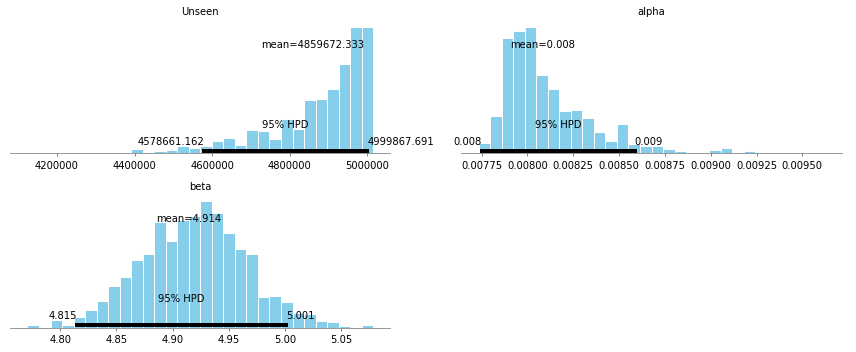

In [109]:
pm.plot_posterior(posterior, varnames = ['Unseen', 'alpha', 'beta']);

<BarContainer object of 36 artists>

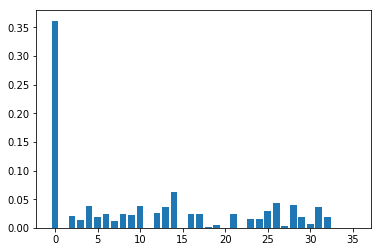

In [115]:
# Percentage of Super-population Arrivals
plt.bar(np.arange(S), posterior['arrival'][-1])

<BarContainer object of 35 artists>

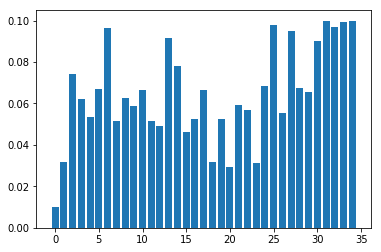

In [116]:
# Percentage of Departures
plt.bar(np.arange(S-1), posterior['departure'][-1])